# Analiza mreže javnog gradskog prevoza u Beogradu

### Opis grafa
TODO

Podešavanje okruženja:
+ pip install ipykernel
+ pip install numpy scipy networkx pandas matplotlib
+ pip install scikit-learn python-docx

Linkovi:
+ [Portal otvorenih podataka](https://data.gov.rs/sr/datasets/gtfs/)
+ [General Transit Feed Specification](https://en.wikipedia.org/wiki/GTFS)
+ [Linije javnog prevoza u Beogradu](https://sr.wikipedia.org/sr-el/%D0%9B%D0%B8%D0%BD%D0%B8%D1%98%D0%B5_%D1%98%D0%B0%D0%B2%D0%BD%D0%BE%D0%B3_%D0%BF%D1%80%D0%B5%D0%B2%D0%BE%D0%B7%D0%B0_%D1%83_%D0%91%D0%B5%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D1%83)
+ [Sekretarijat za javni prevoz](https://www.bgprevoz.rs/)

### Globalne stvari

In [59]:
# importi

from datetime import datetime, date, timedelta
import math
import cpnet #https://github.com/skojaku/core-periphery-detection
import numpy as np
import scipy.stats as stats
import networkx as nx
import powerlaw #https://pythonhosted.org/powerlaw/
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from itertools import chain, combinations
from sklearn.cluster import SpectralClustering
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from numpy import linalg
import os

# putanje
original_path = "../data/!original/"
clean_path = "../data/clean/"
report_path = "../report"
graphs_path = "../data/graphs/"
spectral_path = "../data/spectral_analysis/"

# globalne funkcije

def series_to_single_value(series):
    return series.to_list()[0]

def cleaned_null_columns(df:pd.DataFrame):
    non_null_columns = [column for column in df.columns if not df[column].isna().all()]
    return df[non_null_columns]

def cleaned_duplicates(df:pd.DataFrame):
    no_duplicates = df.drop_duplicates()
    number_of_duplicates = df.shape[0] - no_duplicates.shape[0]
    print(f"Number of duplicates is {number_of_duplicates}")
    return no_duplicates

def cleaned_data_frame(df:pd.DataFrame):
    return cleaned_duplicates(cleaned_null_columns(df))


def is_valid_datetime_str(datetime_str):
    format_str = "%H:%M:%S"
    try:
        datetime.strptime(datetime_str, format_str)
        return True
    except ValueError:
        return False
    except TypeError:
        return False

def midnight_converter(datetime_str):
    if (not str.startswith(datetime_str, "24")):
        return datetime_str
    else:
        return "00" + datetime_str[2:]

def safely_remove_edge(G:nx.Graph, edge):
    u, v = edge
    if G.has_edge(u, v):
        G.remove_edge(u, v)

def graph_to_df(G:nx.Graph):
    pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').reset_index()

### Čišćenje podataka

In [1]:
# # # Originalni podaci se čuvaju u data/!original/ folderu.
# Prečišćeni podaci se čuvaju u data/clean/ folderu.
# BgNetLWalk podaci se čuvaju u data/consolidate/ folderu.    


df_agency = pd.read_csv(f"{original_path}/agency.csv")
df_calendar_dates = pd.read_csv(f"{original_path}/calendar_dates.csv")
df_calendar = pd.read_csv(f"{original_path}/calendar.csv")
df_fare_attributes = pd.read_csv(f"{original_path}/fare_attributes.csv")
df_fare_rules = pd.read_csv(f"{original_path}/fare_rules.csv")
df_feed_info = pd.read_csv(f"{original_path}feed_info.csv")
df_frequencies = pd.read_csv(f"{original_path}/frequencies.csv")#? Treba li da radimo u opstem slucaju i pravimo da ova tabela postoji, ili je bas poenta da je ignorisemo
df_routes = pd.read_csv(f"{original_path}/routes.csv")
df_shapes = pd.read_csv(f"{original_path}/shapes.csv")
df_stops = pd.read_csv(f"{original_path}/stops.csv")
df_stop_times = pd.read_csv(f"{original_path}/stop_times.csv", dtype={"stop_headsign":np.string_})
df_transfers = pd.read_csv(f"{original_path}/transfers.csv")
df_trips = pd.read_csv(f"{original_path}/trips.csv")




all_frames = [df_agency, df_calendar_dates, df_calendar, df_fare_attributes, df_fare_rules, df_feed_info, df_frequencies, df_routes, df_shapes, df_stops, df_stop_times, df_transfers, df_trips]
all_frames_cleaned = [cleaned_data_frame(df) for df in all_frames]




NameError: name 'pd' is not defined

In [2]:
[df_agency, df_calendar_dates, df_calendar, df_fare_attributes, df_fare_rules, df_feed_info, df_frequencies, df_routes, df_shapes, df_stops, df_stop_times, df_transfers, df_trips] = all_frames_cleaned


df_stop_times.loc[df_stop_times["arrival_time"].apply(lambda x: not is_valid_datetime_str(x)), "arrival_time"] = pd.NA
df_stop_times.loc[df_stop_times["departure_time"].apply(lambda x: not is_valid_datetime_str(x)), "departure_time"] = pd.NA


df_agency.to_csv(f"{clean_path}/agency.csv", index=False)
df_calendar_dates.to_csv(f"{clean_path}/calendar_dates.csv", index=False)
df_calendar.to_csv(f"{clean_path}/calendar.csv", index=False)
df_fare_attributes.to_csv(f"{clean_path}/fare_attributes.csv", index=False)
df_fare_rules.to_csv(f"{clean_path}/fare_rules.csv", index=False)
df_feed_info.to_csv(f"{clean_path}/feed_info.csv", index=False)
df_frequencies.to_csv(f"{clean_path}/frequencies.csv", index=False)
df_routes.to_csv(f"{clean_path}/routes.csv", index=False)
df_shapes.to_csv(f"{clean_path}/shapes.csv", index=False)
df_stops.to_csv(f"{clean_path}/stops.csv", index=False)
df_stop_times.to_csv(f"{clean_path}/stop_times.csv", index=False)
df_transfers.to_csv(f"{clean_path}/transfers.csv", index=False)
df_trips.to_csv(f"{clean_path}/trips.csv", index=False)

NameError: name 'all_frames_cleaned' is not defined

In [2]:
df_agency = pd.read_csv(f"{clean_path}/agency.csv")
df_calendar_dates = pd.read_csv(f"{clean_path}/calendar_dates.csv")
df_calendar = pd.read_csv(f"{clean_path}/calendar.csv")
df_fare_attributes = pd.read_csv(f"{clean_path}/fare_attributes.csv")
df_fare_rules = pd.read_csv(f"{clean_path}/fare_rules.csv")
df_feed_info = pd.read_csv(f"{clean_path}/feed_info.csv")
df_routes = pd.read_csv(f"{clean_path}/routes.csv")
df_shapes = pd.read_csv(f"{clean_path}/shapes.csv")
df_stops = pd.read_csv(f"{clean_path}/stops.csv")
df_stop_times = pd.read_csv(f"{clean_path}/stop_times.csv", dtype={"stop_headsign":np.string_})
df_trips = pd.read_csv(f"{clean_path}/trips.csv")


#print(df_routes["route_type"].unique()) #rezultati (0,3, 702, 800) 0 - tramvaj, 3 - autobus, 702 - ekspres autobus, 800 - trolejbus
route_type_names = {0:"Tramvaj", 3:"Autobus", 702:"Autobus", 800:"Trolejbus"}
df_routes["route_type_name"] = df_routes["route_type"].map(route_type_names)

### Statistička obrada podataka [5 poena]
1) Odrediti prosečno vreme između dva polaska svake od linija. Koje su linije sa najčešćim, a koje sa najređim polascima?
2) Koje su linije sa najvećim brojem stanica, a koje stanice sa najvećim brojem linija?
3) Preračunati očekivani dnevni promet stanice kao ukupan očekivani broj stajanja linije na toj stanici, određen na osnovu planiranog rasporeda vožnje. Koje su stanice sa najvećim očekivanim dnevnim prometom?
4) Svakoj stanici dodeliti tip na osnovu vrsta prevoza koje prolaze njom (stanica autobusa, tramvaja, trolejbusa ili meštovita stanica). Koliko ima stanica svakog tipa?

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,timepoint
0,665800,20:00:00,20:00:00,638,1,NaN,0
1,665800,20:01:00,20:01:00,148,2,NaN,0
2,665800,20:02:00,20:02:00,746,3,NaN,0
3,665800,20:04:00,20:04:00,845,4,NaN,0
4,665800,20:06:00,20:06:00,847,5,NaN,0
...,...,...,...,...,...,...,...
1648776,1494173,23:11:00,23:11:00,1289,20,NaN,0
1648777,1494173,23:13:00,23:13:00,1291,21,NaN,0
1648778,1494173,23:14:00,23:14:00,1293,22,NaN,0
1648779,1494173,23:16:00,23:16:00,1295,23,NaN,0


In [4]:
# 1) Odrediti prosečno vreme između dva polaska svake od linija.
# Koje su linije sa najčešćim, a koje sa najređim polascima?

# TODO
def find_average_departure_times_for_stops():
    def get_average_wait(departure_times_str):
        def convert_to_time(time_str):
            time_object = datetime.strptime(time_str, '%H:%M:%S').time()
            return time_object
        departure_times = [convert_to_time(time_str) for time_str in departure_times_str if is_valid_datetime_str(time_str)]
        departure_times = sorted(departure_times)
        average_timedelta = timedelta(0)
        num_elements = len(departure_times)
        for index in range(1, len(departure_times)):
            prev = index - 1
            duration = datetime.combine(date.min, departure_times[index]) - datetime.combine(date.min, departure_times[prev])
            average_timedelta = average_timedelta + duration  
        if num_elements == 0:
            inf = 25*60
            return pd.NA
        average_timedelta = average_timedelta / num_elements
        return average_timedelta 
    
    route_names_dict = df_routes[["route_id", "route_short_name"]].to_dict()

    trips_with_route_name = pd.merge(df_trips, df_routes[["route_id", "route_short_name"]], how="inner", on="route_id")
    stop_times_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id", "departure_time"]], trips_with_route_name[["trip_id", "route_id", "route_short_name", "service_id"]], how="inner", on="trip_id")[["stop_id", "departure_time", "route_id", "route_short_name", "service_id"]]
    stop_times_with_routes_grouped = stop_times_with_route_id.groupby(["stop_id", "route_id", "route_short_name", "service_id"])["departure_time"].apply(lambda x: get_average_wait(list(x)))
    stop_times_with_route_id_waits = pd.DataFrame(stop_times_with_routes_grouped)
    stop_times_with_routes_sorted = stop_times_with_route_id_waits.sort_values("departure_time")
    stop_times_with_routes_sorted = stop_times_with_routes_sorted.rename(columns={"departure_time":"average_wait"})
    stop_times_with_routes_sorted = stop_times_with_routes_sorted.dropna(subset=["average_wait"])
    stop_times_with_routes_sorted = stop_times_with_routes_sorted[stop_times_with_routes_sorted["average_wait"] != timedelta(0)]
    
    return stop_times_with_routes_sorted

def find_average_departure_times_for_starting_stops():
    def get_average_wait(departure_times_str):
        def convert_to_time(time_str):
            time_object = datetime.strptime(time_str, '%H:%M:%S').time()
            return time_object
        departure_times = [convert_to_time(time_str) for time_str in departure_times_str if is_valid_datetime_str(time_str)]
        departure_times = sorted(departure_times)
        average_timedelta = timedelta(0)
        num_elements = len(departure_times)
        for index in range(1, len(departure_times)):
            prev = index - 1
            duration = datetime.combine(date.min, departure_times[index]) - datetime.combine(date.min, departure_times[prev])
            average_timedelta = average_timedelta + duration  
        if num_elements == 0:
            inf = 25*60
            return pd.NA
        average_timedelta = average_timedelta / num_elements
        return average_timedelta 
    
    route_names_dict = df_routes[["route_id", "route_short_name"]].to_dict()

    trips_with_route_name = pd.merge(df_trips, df_routes[["route_id", "route_short_name"]], how="inner", on="route_id")
    stop_times_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id", "departure_time", "stop_sequence"]], trips_with_route_name[["trip_id", "route_id", "route_short_name", "service_id"]], how="inner", on="trip_id")[["stop_id", "departure_time", "route_id", "route_short_name", "service_id", "stop_sequence"]]
    stop_times_with_route_id = stop_times_with_route_id.loc[stop_times_with_route_id["stop_sequence"] == 1]
    stop_times_with_routes_grouped = stop_times_with_route_id.groupby(["stop_id", "route_id", "route_short_name", "service_id"])["departure_time"].apply(lambda x: get_average_wait(list(x)))
    stop_times_with_route_id_waits = pd.DataFrame(stop_times_with_routes_grouped)
    stop_times_with_routes_sorted = stop_times_with_route_id_waits.sort_values("departure_time")
    stop_times_with_routes_sorted = stop_times_with_routes_sorted.rename(columns={"departure_time":"average_wait"})
    stop_times_with_routes_sorted = stop_times_with_routes_sorted.dropna(subset=["average_wait"])
    stop_times_with_routes_sorted = stop_times_with_routes_sorted[stop_times_with_routes_sorted["average_wait"] != timedelta(0)]
    
    return stop_times_with_routes_sorted

stop_times_with_routes_sorted = find_average_departure_times_for_stops() 
stop_times_with_routes_sorted = stop_times_with_routes_sorted.reset_index()
stop_times_with_routes_sorted = pd.merge(stop_times_with_routes_sorted, df_stops[["stop_id", "stop_name"]], on="stop_id", how="inner")
stop_times_with_routes_sorted = stop_times_with_routes_sorted[["route_short_name", "stop_name", "service_id", "average_wait"]]
stop_times_with_routes_one_service = stop_times_with_routes_sorted.loc[stop_times_with_routes_sorted["service_id"] == "Zimski-Radni Dan"][["route_short_name", "stop_name","average_wait"]]
stop_times_with_routes_sorted.to_csv(f"{report_path}/vremena_sve_stanice.csv", index=True)
stop_times_with_routes_one_service.to_csv(f"{report_path}/vremena_sve_stanice_radni_dan_zimski.csv")

stop_times_with_routes_sorted = find_average_departure_times_for_starting_stops() 
stop_times_with_routes_sorted = stop_times_with_routes_sorted.reset_index()
stop_times_with_routes_sorted = pd.merge(stop_times_with_routes_sorted, df_stops[["stop_id", "stop_name"]], on="stop_id", how="inner")
stop_times_with_routes_sorted = stop_times_with_routes_sorted[["route_short_name", "stop_name", "service_id", "average_wait"]]
stop_times_with_routes_one_service = stop_times_with_routes_sorted.loc[stop_times_with_routes_sorted["service_id"] == "Zimski-Radni Dan"][["route_short_name", "stop_name","average_wait"]]
stop_times_with_routes_sorted.to_csv(f"{report_path}/vremena_sve_pocetne_stanice.csv", index=True)
stop_times_with_routes_one_service.to_csv(f"{report_path}/vremena_sve_pocetne_stanice_radni_dan_zimski.csv")


In [12]:
# 2) Koje su linije sa najvećim brojem stanica, a koje stanice sa najvećim brojem linija?



def find_routes_with_most_stops():
    stop_times_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "route_id"]], how="inner", on="trip_id")
    route_ids_with_num_stops = stop_times_with_route_id.groupby("route_id")["stop_id"].nunique().reset_index(name='number_of_distinct_stop_ids')
    route_with_most_stops_with_names = pd.merge(df_routes[["route_id", "route_short_name"]], route_ids_with_num_stops, how="inner", on="route_id")
    route_with_most_stops_with_names = route_with_most_stops_with_names[["route_short_name", "number_of_distinct_stop_ids"]]
    route_with_most_stops_with_names = route_with_most_stops_with_names.sort_values(by="number_of_distinct_stop_ids", ascending=False)
    return route_with_most_stops_with_names


def find_stops_with_most_routes():
    stop_times_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "route_id"]], how="inner", on="trip_id")
    stop_ids_with_num_routes = stop_times_with_route_id.groupby("stop_id")["route_id"].nunique().reset_index(name='number_of_distinct_route_ids')
    stops_with_most_routes_with_names = pd.merge(df_stops[["stop_id", "stop_name"]], stop_ids_with_num_routes, how="inner", on="stop_id")
    stops_with_most_routes_with_names = stops_with_most_routes_with_names[["stop_name", "number_of_distinct_route_ids"]]
    stops_with_most_routes_with_names = stops_with_most_routes_with_names.sort_values(by="number_of_distinct_route_ids", ascending=False)
    return stops_with_most_routes_with_names


routes_with_most_stops = find_routes_with_most_stops()
stops_with_most_routes = find_stops_with_most_routes()
routes_with_most_stops.to_csv(f"{report_path}/linije_sa_najvise_stanica.csv")
stops_with_most_routes.to_csv(f"{report_path}/stanice_sa_najvise_linija.csv")



In [23]:
# 3) Preračunati očekivani dnevni promet stanice kao ukupan očekivani broj stajanja linije na toj stanici,
# određen na osnovu planiranog rasporeda vožnje. Koje su stanice sa najvećim očekivanim dnevnim prometom?

# TODO: Veliko je pitanje da li se ovi tripovi upisuju svakoga dana ili, kao sto cu za sad pretpostaviti, 
# planirani generalno za dan, tj. da ne moram da delim sa brojem dana.  

# TODO: Rezultati su krajnje sumnjivi


def get_stops_with_most_traffic():
    stops_with_trips = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "service_id"]], how="inner", on="trip_id")
    #stops_with_trips = pd.merge(stop_ids_with_trips, df_stops[["stop_name", "stop_id"]], how="inner", on="stop_id")[["stop_name", "service_id", "trip_id"]]
    stops_with_trips_grouped = stops_with_trips.groupby(["stop_id", "service_id"]).nunique()
    stops_with_trips_sorted =  stops_with_trips_grouped.sort_values("trip_id", ascending=False)
    stops_with_trips_sorted_with_names = pd.merge(df_stops[["stop_name", "stop_id"]], stops_with_trips_sorted, on="stop_id", how= "inner").sort_values("trip_id", ascending=False)
    return stops_with_trips_sorted_with_names[["stop_name", "trip_id"]].rename(columns={"trip_id":"Number of trips"})

stops_with_most_traffic = get_stops_with_most_traffic()
stops_with_most_traffic.to_csv(f"{report_path}/stanice_sa_najvecim_protokom.csv")


,stop_name,Number of trips
1386,Sajam,1684
354,Karađorđev Park,1656
1383,Sajam,1656
1407,Ada Ciganlija,1654
351,Karađorđev Park,1649
...,...,...
3604,Mihajla Šolohova,3
539,Bregalnička,3
3603,Mihajla Šolohova,3
533,Crveni Krst,3


In [25]:
# 4) Svakoj stanici dodeliti tip na osnovu vrsta prevoza koje prolaze njom
# (stanica autobusa, tramvaja, trolejbusa ili meštovita stanica). Koliko ima stanica svakog tipa?

# TODO Da li je ovde bitan smer?
def get_stops_with_route_type():
    stops_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "route_id"]], how="inner", on="trip_id")
    stops_with_route_type = pd.merge(stops_with_route_id[["stop_id", "route_id"]], df_routes[["route_id", "route_type_name"]], how="inner", on="route_id")[["stop_id", "route_type_name"]]
    stops_with_route_type = pd.DataFrame(stops_with_route_type.groupby('stop_id')['route_type_name'].apply(lambda x: ', '.join(x.unique())))
    stops_with_route_type.loc[stops_with_route_type['route_type_name'].str.contains(","), 'route_type_name'] = "Mesano"
    return stops_with_route_type

def count_stops_per_route_type(stops_with_route_type:pd.DataFrame):
    route_types_with_num_stops = stops_with_route_type.groupby("route_type_name")["stop_id"].nunique().reset_index(name="Number of stops")
    return route_types_with_num_stops


stops_with_route_type = get_stops_with_route_type()
stops_with_route_type_full = pd.merge(df_stops, stops_with_route_type, how="inner", on="stop_id")
stops_with_route_type_full.to_csv(f"{clean_path}/stops_with_route_type.csv", index=False)
route_types_with_num_stops = count_stops_per_route_type(stops_with_route_type_full)
route_types_with_num_stops.to_csv(f"{report_path}/tipovi_stanica_za_vozilo.csv")


### Pravljenje mrežnih modela 

In [3]:
#Pomocne funkcije

def calculate_distance(G, u,v):
        def sqr(t):
            return t * t
        att_u = G.nodes[u]
        att_v = G.nodes[v]
        lat1, lon1 = att_u["lat"], att_u["lon"]
        lat2, lon2 = att_v["lat"], att_v["lon"]
        t1 = sqr(math.sin((lat1 - lat2)/2))
        t2 = sqr(math.sin((lon1 - lon2)/2))
        R = 6371
        return 2 * R * math.asin(math.sqrt(t1 + t2 * math.cos(lat1) * math.cos(lat2)))

# G je graf stanica, cvorovi imaju, lat i lon



def merge_stops_union_find(G:nx.Graph):
    BgNetWalk = G.copy()
    
    parent = {}
    level = {}
    for u in G.nodes():
        parent[u] = u
        level[u] = 1

    #TODO: Testiraj union find
    def find(u):
        curr = u
        next = parent[u]
        while curr != next:
            curr, next = next, parent[next]
        return curr
    def union(u, v):
        find_u = find(u)
        find_v = find(v)
        if find_u == find_v:
            return
        if level[u] < level[v]:
            parent[u] = find_v
            parent[v] = find_v
            return
        if level[v] < level[u]:
            parent[u] = find_u
            parent[v] = find_v
            return
        if level[u] == level[v]:
            new_level = level[u] + 1
            parent[u] = find_u
            parent[v] = find_u
            level[u] = new_level
            level[v] = new_level

    for u,v in combinations(G, 2):
        d = calculate_distance(G, u, v)
        treshold = 6 #TODO: Naci smislenu vrednost
        if d < treshold:
            union(u, v)
    groupes = {}
    for u in G.nodes():
        find_u = find(u)
        if find_u not in groupes.keys():
            groupes[find_u] = [u]
        else:
            groupes[find_u].append(u)

    for representative, nodes_list in groupes:
        for node in nodes_list:
            if node != representative:
                BgNetWalk = nx.contracted_nodes(BgNetWalk, representative, node)
    return BgNetWalk



In [4]:

#BgNetL, BgWalkNetL
#Cvorovi su stanice koje su povezane ukoliko su susedne stanice neke linije
def make_L_space():
    df_stops_with_order = df_stop_times[["trip_id","stop_id", "stop_sequence"]].drop_duplicates()
    df_stops_with_order = pd.merge(df_stops_with_order, df_stops[["stop_id", "stop_name", "stop_lat", "stop_lon"]], on="stop_id", how="inner").drop_duplicates()
    df_stops_with_order_grouped = df_stops_with_order.groupby("trip_id")
    list_of_stops_per_trip = []
    for trip_id, df_grouped_data in df_stops_with_order_grouped:

        sorted_data = df_grouped_data.sort_values(by="stop_sequence")
        stops_for_this_trip = [(stop_id, seq_num, stop_name, stop_lat, stop_lon)  for _, _, stop_id, seq_num, stop_name, stop_lat, stop_lon  in sorted_data.to_records()]

        list_of_stops_per_trip.append((trip_id, stops_for_this_trip))
    
    L = nx.Graph()
    for _, stops in list_of_stops_per_trip:
        #stanice su na istom putu, ergo na istoj ruti, tako da su susedne ako imaju redni broj veci za 1
        for index, (stop_id, seq_num, stop_name, stop_lat, stop_lon) in enumerate(stops):
            if index + 1 < len(stops):
                next_stop_id, next_seq_num, next_stop_name, next_stop_lat, next_stop_lon = stops[index + 1]
                graph_id = f"{stop_name}({stop_id})"
                next_graph_id = f"{next_stop_name}({next_stop_id})"
                if not L.has_node(graph_id):
                    L.add_nodes_from([(graph_id, {'name': stop_name, 'id':stop_id, 'lat': stop_lat, 'lon': stop_lon})])
                if not L.has_node(next_graph_id):
                    L.add_nodes_from([(next_graph_id, {'name': next_stop_name, 'id':next_stop_id, 'lat': next_stop_lat, 'lon': next_stop_lon})])
                L.add_edge(graph_id, next_graph_id)
    return L  
def make_weighted_graph(G:nx.Graph):
    U = G.copy()
    for edge in U.edges():
        u, v = edge
        U.edges()[edge]["weight"] = calculate_distance(G, u, v)
    return U

# Logika funkcije je upisana u izvestaju
# param: G je tezinski graf
def make_walkNet(G:nx.Graph):

    def create_suplementary(G:nx.Graph):
        def testNet(U:nx.Graph, cadidate_name):
            valid = True
            for (u1,v1), (u2, v2) in combinations(U.edges(), 2):
                f1 = ((u1 == u2) and (not U.has_edge(v1, v2))) or ((u1 == v2) and (not U.has_edge(v1, u2)))
                f2 = ((v1 == u2) and (not U.has_edge(u1, v2))) or ((v1 == v2) and (not U.has_edge(u1, u2)))
                if f1 or f2:
                    valid = False
                    break

        U = nx.Graph()
        U.add_nodes_from(G.nodes())
        weights = sorted([G.edges()[edge]["weight"] for edge in G.edges()])
        min_edge_G = 1e9
        for edge in weights:
            if edge > 0:
                min_edge_G = edge
                break
        d_candidates = [ (min_edge_G, "dopuna"), (0.25 * min_edge_G, "dopuna_cetvrtina"), (0.125, "dopuna_osmina"), (0.5, "dopuna_pola")]
        for d, graph_name in d_candidates:
            for (u, v) in combinations(G.nodes(), 2):
                dist = calculate_distance(G, u, v)
                if dist <= d:
                    U.add_edges_from([(u, v)])
            testNet(U, graph_name)
            # Graf dopuna je validan False
            # Graf dopuna_cetvrtina je validan True
            # Graf dopuna_osmina je validan True
            # Graf dopuna_pola je validan True
            nx.write_gexf(U, f"{graphs_path}/{graph_name}.gexf")
            U.clear_edges()
        return nx.read_gexf(f"{graphs_path}/dopuna_pola.gexf")
    U =  nx.read_gexf(f"{graphs_path}/dopuna_pola.gexf") if os.path.isfile(f"{graphs_path}/dopuna_pola.gexf") else create_suplementary(G)
    BgNetLWalk = nx.Graph()
    BgNetLWalk.add_edges_from(G.edges())
    BgNetLWalk.add_edges_from(U.edges())
    return BgNetLWalk

overwrite = True #Biramo ako hocemo sve ispocetka jer je npr. promenjen pristup u pravljenju grafa ili dodani novi atributi

BgNetL_filename = f"{graphs_path}/BGNetL.gexf"
BgNetLWeighted_filename = f"{graphs_path}/BGNetLWeighted.gexf"
BgNetLWalk_filename = f"{graphs_path}/BGNetLWalk.gexf"

BgNetL = nx.read_gexf(BgNetL_filename) if (not overwrite) and os.path.isfile(BgNetL_filename) else make_L_space()
BgNetLWeighted = nx.read_gexf(BgNetLWeighted_filename) if (not overwrite) and os.path.isfile(BgNetLWeighted_filename) else make_weighted_graph(BgNetL)
BgNetLWalk = nx.read_gexf(BgNetLWalk_filename) if (not overwrite) and os.path.isfile(BgNetLWalk_filename) else make_walkNet(BgNetLWeighted)

if overwrite or (not os.path.isfile(BgNetL_filename)):
    nx.write_gexf(BgNetL, BgNetL_filename)
if overwrite or (not os.path.isfile(BgNetLWeighted_filename)):
    nx.write_gexf(BgNetLWeighted, BgNetLWeighted_filename)
if overwrite or (not os.path.isfile(BgNetLWalk_filename)):
    nx.write_gexf(BgNetLWalk, BgNetLWalk_filename)





In [19]:
#Cvorovi su linije koje su povezane ukoliko prolaze kroz istu stanicu

def make_C_space():
    stops_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "route_id"]], how="inner", on="trip_id")
    stops_with_route_id = stops_with_route_id[["stop_id", "route_id"]].drop_duplicates()#TODO: Proveriti da li je problem ispustanje trip_id
    stops_with_route_name = pd.merge(stops_with_route_id, df_routes[["route_id", "route_short_name"]])[["stop_id", "route_short_name"]]
    stops_with_route_name_grouped = stops_with_route_name.groupby("stop_id")
    list_of_routes_with_a_given_stop = []
    cnt = 20
    for stop_id, df_grouped_data in stops_with_route_name_grouped:
        routes_through_a_given_stop = [route_short_name for index, stop_id, route_short_name in df_grouped_data.to_records()]
        list_of_routes_with_a_given_stop.append(routes_through_a_given_stop)
        # print(f"Sve linije na stanici {stop_id} su {routes_through_a_given_stop}.\r\n Sve stanice ukupno su {list_of_routes_with_a_given_stop}")
        # cnt = cnt - 1
        # if cnt == 0:
        #     break

    G = nx.Graph()
    for routes_with_a_given_stop in list_of_routes_with_a_given_stop:
        edges = [edge for edge in combinations(routes_with_a_given_stop, 2)]
        G.add_edges_from(edges)
    return G

overwrite = True #Biramo ako hocemo sve ispocetka jer je npr. promenjen pristup u pravljenju grafa ili dodani novi atributi

BgNetC_filename = f"{graphs_path}/BgNetC.gexf"

BgNetC = nx.read_gexf(BgNetC_filename) if (not overwrite) and os.path.isfile(BgNetC_filename) else make_C_space()

if overwrite or os.path.isfile(BgNetC_filename):
    nx.write_gexf(BgNetC, BgNetC_filename)

In [5]:
#Cvorovi su stanice koje su povezane ako imaju zajednicku liniju

def make_P_space_old():
    stops_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "route_id"]], how="inner", on="trip_id")
    stops_with_route_id = stops_with_route_id[["stop_id", "route_id"]].drop_duplicates()#TODO: Proveriti da li je problem ispustanje trip_id
    stops_routes_pairs_grouped = stops_with_route_id.groupby("route_id")
    list_of_stops_on_the_same_route = []
    for route_id, df_stops_on_route in stops_routes_pairs_grouped:
        stops_on_this_route = [stop_id for index, stop_id, route_id in df_stops_on_route.to_records()]
        list_of_stops_on_the_same_route.append(stops_on_this_route)
    #Moglo je odmah da se ubaci u graf, ali radi testiranja je odvojeno
    G = nx.Graph()
    for stops_on_a_given_route in list_of_stops_on_the_same_route:
        edges = [edge for edge in combinations(stops_on_a_given_route, 2)]
        G.add_edges_from(edges)
    return G

def make_P_space():
    df_stops_with_order = df_stop_times[["trip_id","stop_id", "stop_sequence"]].drop_duplicates()
    df_stops_with_order = pd.merge(df_stops_with_order, df_stops[["stop_id", "stop_name", "stop_lat", "stop_lon"]], on="stop_id", how="inner").drop_duplicates()
    df_stops_with_order_grouped = df_stops_with_order.groupby("trip_id")
    list_of_stops_per_trip = []
    for trip_id, df_grouped_data in df_stops_with_order_grouped:
        stops_for_this_trip = [(stop_id, stop_name, stop_lat, stop_lon)  for _, _, stop_id, seq_num, stop_name, stop_lat, stop_lon  in df_grouped_data.to_records()]
        list_of_stops_per_trip.append((trip_id, stops_for_this_trip))
    
    P = nx.Graph()
    for _, stops in list_of_stops_per_trip:
        #stanice su na istom putu, ergo na istoj ruti, tako da su susedne ako imaju redni broj veci za 1
        # for index, (stop_id, seq_num, stop_name, stop_lat, stop_lon) in enumerate(stops):
        for stop_pair in combinations(stops, 2):
            first_stop, second_stop = stop_pair
            first_stop_id, first_stop_name, first_stop_lat, first_stop_lon = first_stop
            second_stop_id, second_stop_name, second_stop_lat, second_stop_lon = second_stop
            
            first_graph_id = f"{first_stop_name}({first_stop_id})"
            second_graph_id = f"{second_stop_name}({second_stop_id})"
            if not P.has_node(first_graph_id):
                P.add_nodes_from([(first_graph_id, {'name': first_stop_name, 'id':first_stop_id, 'lat': first_stop_lat, 'lon': first_stop_lon})])
            if not P.has_node(second_graph_id):
                P.add_nodes_from([(second_graph_id, {'name': second_stop_name, 'id':second_stop_id, 'lat': second_stop_lat, 'lon': second_stop_lon})])
            P.add_edge(first_graph_id, second_graph_id)
    return P  

P = make_P_space()

overwrite = True #Biramo ako hocemo sve ispocetka jer je npr. promenjen pristup u pravljenju grafa ili dodani novi atributi

BgNetP_filename = f"{graphs_path}/BgNetP.gexf"


BgNetP = nx.read_gexf(BgNetP_filename) if (not overwrite) and os.path.isfile(BgNetP_filename) else make_P_space()

if overwrite or os.path.isfile(BgNetP_filename):
    nx.write_gexf(BgNetP, BgNetP_filename)

In [21]:
df_shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,00002_shape_0,44.819244,20.449545,0,0.00000
1,00002_shape_0,44.819631,20.449592,1,0.04331
2,00002_shape_0,44.819757,20.449578,2,0.05740
3,00002_shape_0,44.819856,20.449488,3,0.07053
4,00002_shape_0,44.820151,20.449030,4,0.11945
...,...,...,...,...,...
58672,90004_shape_1,44.743850,20.516491,138,11.41591
58673,90004_shape_1,44.744157,20.516754,139,11.45597
58674,90004_shape_1,44.744311,20.516967,140,11.48004
58675,90004_shape_1,44.744838,20.518162,141,11.59142


### Osnovna karakterizacija modelovanih mreža [10 poena]
5) Kolika je gustina mreže?
6) Kolike su prosečne distance u okviru mreže i dijametar mreže?
7) U kojoj meri je mreža povezana i centralizovana? Navesti broj i veličine povezanih komponenata i proceniti da li postoji gigantska komponenta.
8) Koliki je prosečni, a koliki globalni koeficijent klasterizacije mreže? Kakva je raspodela lokalnog koeficijenta klasterizacije njenih čvorova? Da li je klasterisanje izraženo ili ne? Odgovor dati upoređivanjem sa slučajno generisanim Erdos-Renyi i scale free mrežama istih dimenzija.
9) Na osnovu odgovora na pitanja 6 i 8, proceniti da li mreža iskazuje osobine malog sveta.
10) Izvršiti asortativnu analizu po stepenu čvora i dati odgovor da li je izraženo asortativno mešanje. Priložiti i vizuelizaciju.
11) Da li mreža ispoljava fenomen kluba bogatih (eng. rich club phenomenon)?
12) Analizirati stajališta na osnovu tarifne zone kojoj pripadaju. Ispitati da li BGNetL i BGNetP mreže odgovaraju modelu jezgra i periferije (core-periphery model). Smatrati da prva zona pripada jezgru, a ostale periferiji.
13) Kakva je distribucija čvorova po stepenu i da li prati power law raspodelu?

In [5]:
# 5) Kolika je gustina mreže?

#TODO
def print_density(G:nx.Graph, name):
    print(f'Gustina {name}-prostora je: {nx.density(G)}, broj grana po cvoru je {G.number_of_edges() / G.number_of_nodes()}')

print_density(BgNetL, "BGNetL")


Gustina L-prostora je: 0.0007880519963201096, broj grana po cvoru je 1.2329073482428115


In [6]:
# 6) Kolike su prosečne distance u okviru mreže i dijametar mreže?

#TODO
def print_distance_and_diameter(G:nx.Graph, name):
    print(f'Prosecna distanca u grafu {name} je {nx.average_shortest_path_length(G)}, a dijametar je {nx.diameter(G)}')
print_distance_and_diameter(BgNetL, "L")
# print_distance_and_diameter(P_space, "P")
# print_distance_and_diameter(C_space, "C")


Prosecna distanca u grafu L je 26.19037143000091, a dijametar je 101


In [8]:
# 7) U kojoj meri je mreža povezana i centralizovana?
# Navesti broj i veličine povezanih komponenata i proceniti da li postoji gigantska komponenta.

#TODO
def print_centrality(G:nx.Graph, name):
    # print(f"Centralnost mreze je {nx.centrality(G)}")
    components_lengths = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    print(f"Postoji: {len(components_lengths)} povezanih komponenti, velicine:{components_lengths}")
    

print_centrality(BgNetL,"L")
# print_centrality(make_C_space(),"C")
# print_centrality(make_P_space(),"P")

Postoji: 1 povezanih komponenti, velicine:[3130]


Prosecni lokalni koeficijent klasterizacije za L-prostor je 0.01774075764491101, a globalni je 0.03278008298755187
Analog probability is 0.0007880519963201096
Prosecni lokalni koeficijent klasterizacije za ER(1/lnN) je 0.12452257038719466, a globalni je 0.12452483655821994
Prosecni lokalni koeficijent klasterizacije za ER je 0.0011501597444089457, a globalni je 0.0009462727368310378
Prosecni lokalni koeficijent klasterizacije za scale-free mreza je 0.012713007200648021, a globalni je 0.00421084292052034


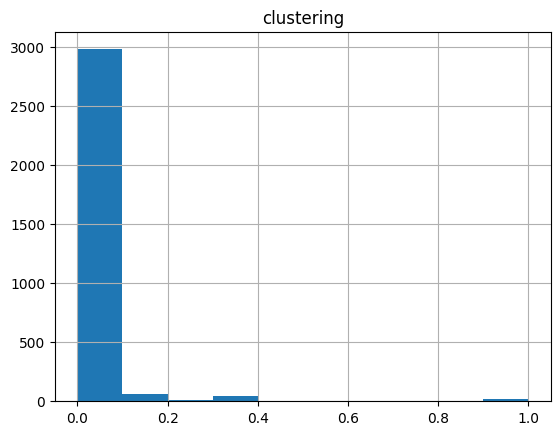

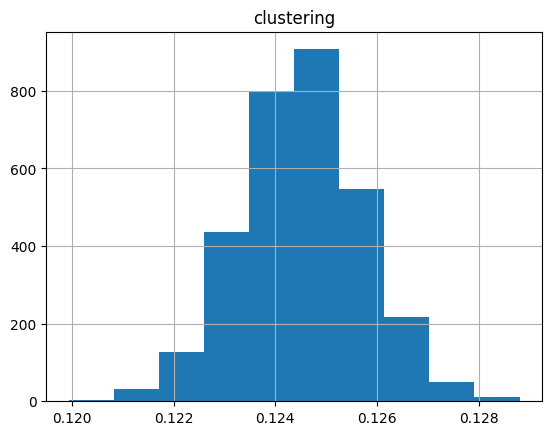

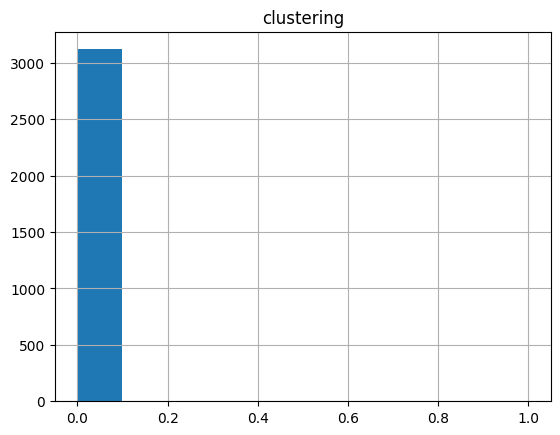

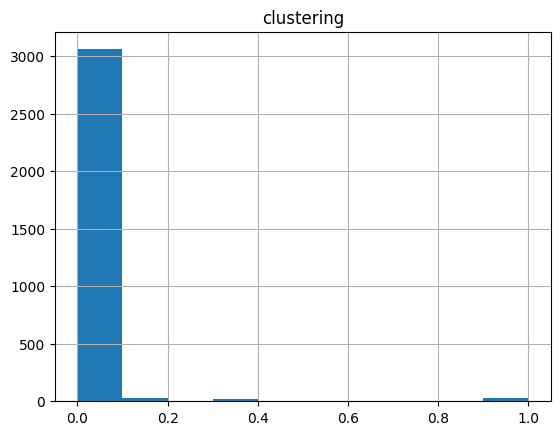

In [37]:
# 8) Koliki je prosečni, a koliki globalni koeficijent klasterizacije mreže?
# Kakva je raspodela lokalnog koeficijenta klasterizacije njenih čvorova?
# Da li je klasterisanje izraženo ili ne?
# Odgovor dati upoređivanjem sa slučajno generisanim Erdos-Renyi i scale free mrežama istih dimenzija.

#TODO

def print_and_compare_clusterization(G:nx.Graph, graph_name):

    def print_clusterization(G:nx.Graph, graph_name):
        print(f"Prosecni lokalni koeficijent klasterizacije za {graph_name} je {nx.average_clustering(G)}, a globalni je {nx.transitivity(G)}")
        clustering = nx.clustering(G)
        # plt.plot(clustering.keys(), clustering.values(), color ="red")
        df_clustering = pd.DataFrame(list(clustering.items()), columns=["node", "clustering"])
        df_clustering = df_clustering[["clustering"]]
        df_clustering.hist()
        
                
    print_clusterization(G, graph_name)

    N = G.number_of_nodes()
    M = G.number_of_edges()
    analog_probability = nx.density(G)
    print(f"Analog probability is {analog_probability}")
    
    interesting_probabilities = [1 / math.log(N), analog_probability]
    ER_list = [nx.erdos_renyi_graph(N, p) for p in interesting_probabilities]
    ER_names = ["ER(1/lnN)", "ER"]
    AB = nx.barabasi_albert_graph(N, (2*M) // N)

    for ER_name, ER in zip(ER_names, ER_list):
        print_clusterization(ER, ER_name)
    print_clusterization(AB, "scale-free mreza")


print_and_compare_clusterization(BgNetL, "L-prostor")


#OUTPUT:
# Prosecni lokalni koeficijent klasterizacije za L-prostor je 0.01807089609006543, a globalni je 0.03316749585406302
# Prosecni lokalni koeficijent klasterizacije za 1/ln(N) je 0.12422540150658502, a globalni je 0.1242254829745278
# Prosecni lokalni koeficijent klasterizacije za ista verovatnoca kao u datom grafu je 0.0007926365434352655, a globalni je 0.0010523854069223574
# Prosecni lokalni koeficijent klasterizacije za scale-free mreza je 0.010949827598069487, a globalni je 0.003658937674724552
# Prosecni lokalni koeficijent klasterizacije za C-prostor je 0.6139194322268351, a globalni je 0.5026952069406913
# Prosecni lokalni koeficijent klasterizacije za 1/ln(N) je 0.18416917159209523, a globalni je 0.18412205844323765
# Prosecni lokalni koeficijent klasterizacije za ista verovatnoca kao u datom grafu je 0.15104635540863326, a globalni je 0.15144727773949002
# Prosecni lokalni koeficijent klasterizacije za scale-free mreza je 0.3616530044388497, a globalni je 0.34726646853819676
# Prosecni lokalni koeficijent klasterizacije za P-prostor je 0.7571769606905687, a globalni je 0.4723968113751248
# Prosecni lokalni koeficijent klasterizacije za 1/ln(N) je 0.1241903762835847, a globalni je 0.1241880275161438
# Prosecni lokalni koeficijent klasterizacije za ista verovatnoca kao u datom grafu je 0.03882982128959097, a globalni je 0.03883566125599462
# Prosecni lokalni koeficijent klasterizacije za scale-free mreza je 0.14470940820224246, a globalni je 0.147254189367977

#Zakljucci:
#L_Space: klasterizacija nije izrazena, P i C prostor jesu




In [21]:
# 9) Na osnovu odgovora na pitanja 6 i 8, proceniti da li mreža iskazuje osobine malog sveta.

#TODO
def print_small_world_coefficients(G:nx.Graph, name):
    sigma = nx.sigma(G, niter=2)
    omega = 0
    # sigma = 0
    # omega = nx.omega(G, niter=1, nrand=1)
    print(f"Za graf {name} koeficijenti su sigma = {sigma}, omega = {omega}")

print_small_world_coefficients(L_space, "BgNetL")
print_small_world_coefficients(P_space, "BgNetP")
print_small_world_coefficients(C_space, "BgNetC")

#OUTPUT LSPACEomega = -0.5482994459788156
#Za graf BgNetL koeficijenti su sigma = 40.01195330938196, omega = 0

#BGNetL nema odlike malog sveta jer ima velik dijametar i prosecnu distancu, a malu klasterizaciju

Za graf BgNetL koeficijenti su sigma = 40.01195330938196, omega = 0


KeyboardInterrupt: 

In [26]:
# 10) Izvršiti asortativnu analizu po stepenu čvora i dati odgovor
# da li je izraženo asortativno mešanje. Priložiti i vizuelizaciju.

#TODO Asortativnost je tendencija cvorova da se druze sa cvoro
def analyze_assortivity(G:nx.Graph, graph_name):
    print(f"Pirsonov koeficijent korelacije je {nx.degree_pearson_correlation_coefficient(G)}")
    print(f"Koeficijent asortativnosti je {nx.degree_assortativity_coefficient(G)}")

    degrees = dict(G.degree(nx.average_neighbor_degree(G)))
    neighbour_degrees = dict(nx.average_neighbor_degree(G))
    df_analyze_assortivity = pd.merge(pd.DataFrame(list(degrees.items()), columns=["id", "degrees"]), pd.DataFrame(list(neighbour_degrees.items()), columns=["id", "average_neighbour_degree"]), on="id", how="inner")
    

    df_analyze_assortivity = df_analyze_assortivity.sort_values('id')

    # Plot col2 and col3 as lines
    plt.plot(df_analyze_assortivity['id'], df_analyze_assortivity['degrees'], label='degrees')
    plt.plot(df_analyze_assortivity['id'], df_analyze_assortivity['average_neighbour_degree'], label='average_neighbour_degree')

    plt.xlabel('id')
    plt.xticks([])
    plt.ylabel('Vrednosti')
    plt.title('Poredjenje stepena cvora i prosecnog stepena njegovih suseda')
    plt.legend()
    plt.show()

    
G = nx.Graph([(1, 2), (1, 3), (1, 4), (1, 5), (1, 6)])
analyze_assortivity(BgNetL, "BgNetL")

Pirsonov koeficijent korelacije je 0.3197849487809249
Koeficijent asortativnosti je 0.31978494878091823


UnboundLocalError: local variable 'degrees' referenced before assignment

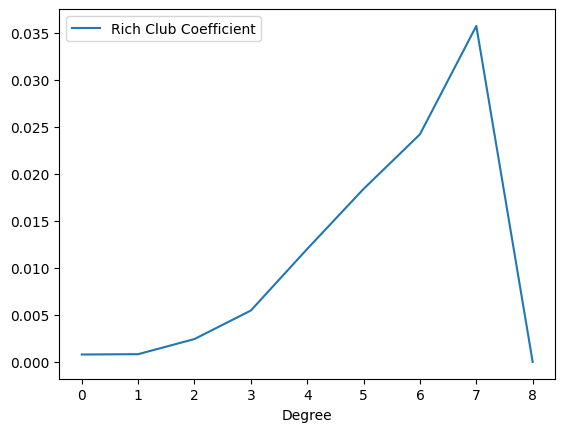

In [25]:
# 11) Da li mreža ispoljava fenomen kluba bogatih (eng. rich club phenomenon)?

#TODO
def analyze_rich_club(G:nx.Graph):
    degree_coef = nx.rich_club_coefficient(G, normalized=False)
    pd_degree_coef = pd.DataFrame(list(degree_coef.items()), columns=['Degree', 'Rich Club Coefficient'])
    pd_degree_coef.plot(x = "Degree", y = "Rich Club Coefficient")
analyze_rich_club(BgNetL)

In [20]:
# 12) Analizirati stajališta na osnovu tarifne zone kojoj pripadaju.
# Ispitati da li BGNetL i BGNetP mreže odgovaraju modelu jezgra i periferije (core-periphery model).
# Smatrati da prva zona pripada jezgru, a ostale periferiji.

#TODO Ovo je cudno, da nema ama bas nikakvog poklapanja za jezgro-periferiju

df_stops_modified = df_stops[["stop_name", "stop_id", "zone_id"]].copy()
df_stops_modified["id"] = df_stops_modified["stop_name"] + "(" + df_stops_modified["stop_id"].astype(str) + ")"

# df_core = df_stops_modified.loc[df_stops_modified["zone_id"] == 1, ["id"]]
# df_periphery = df_stops_modified.loc[df_stops_modified["zone_id"] != 1, ["id"]]

df_stops_modified["coreness_prediction"] = df_stops_modified["zone_id"].apply(lambda x: 1 if x == 1 else 0)
df_stops_modified = df_stops_modified[["id", "coreness_prediction"]]


def print_analyze_core_periphery(G:nx.Graph, graph_name):
    algorithm = cpnet.KM_config(100)
    algorithm.detect(G)
    
    coreness_dict = algorithm.get_coreness()
    df_cpnet_coreness = pd.DataFrame(list(coreness_dict.items()), columns =["id", "coreness_actual"])
    df_joined = pd.merge(df_stops_modified, df_cpnet_coreness, on = "id", how = "inner")

    cm = confusion_matrix(df_joined['coreness_actual'], df_joined['coreness_prediction'])

    print(cm)
    print(f"Kohen kapa skor je {cohen_kappa_score(cm.sum(axis=1), cm.sum(axis=0))}") #Ispada da je 0, za BGNetL

print_analyze_core_periphery(BgNetL, "BgNetL")
# print_analyze_core_periphery(BgNetP, "BGNetP")




,id,coreness_actual
0,0,0
1,1,1
2,2,0
3,3,0
4,4,1
5,5,0
6,6,0
7,7,1
8,8,0
9,9,1


In [26]:
# 13) Kakva je distribucija čvorova po stepenu i da li prati power law raspodelu?

#TODO
def analyze_degree_distribution(G:nx.Graph):
    degrees = sorted([G.degree(n) for n in G.nodes()])
    # plt.hist(degrees)
    # plt.show()
    fit = powerlaw.Fit(degrees, xmin=1, xmax=10)
    fit.cdf()
    plt.show()
    distribution1 = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    distribution2 = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
    distribution3 = fit.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)
    distribution4 = fit.distribution_compare('lognormal', 'stretched_exponential', normalized_ratio=True)
    distribution5 = fit.distribution_compare('lognormal', 'exponential', normalized_ratio=True)
    print(distribution1) #(-77.08931768380421, 0.0)
    print(distribution2) #(-32.74258327735149, 3.871796411502585e-235)
    print(distribution3) #(-34.512302271912645, 5.2449211634361535e-261)
    print(distribution4) #(15.521424437401416, 2.4847336323500272e-54)
    print(distribution5) #(15.521424437401416, 2.4847336323500272e-54)
    print()
    print()

    

N = BgNetL.number_of_nodes()
M = BgNetL.number_of_edges()
AB = nx.barabasi_albert_graph(N, (2*M) // N)

    
analyze_degree_distribution(BgNetL)
analyze_degree_distribution(AB)

(-76.82793831671451, 0.0)
(-32.67470503907509, 3.573015849790945e-234)
(-34.467695845903314, 2.4459702112502924e-260)
(15.456771557269857, 6.791828930838097e-54)
(18.175707210628442, 8.0385508937307e-74)


(-82.90025988850265, 0.0)
(-51.84560943119692, 0.0)
(-47.551639081799195, 0.0)
(28.170820727609783, 1.3322932895354186e-174)
(24.007443214202027, 2.3250908820188275e-127)




### Analiza mera centralnosti [5 poena]
14) Sprovesti analize centralnosti po stepenu, bliskosti i relacionoj centralnosti. Dati pregled najvažnijih aktera po svakoj od njih.
15) Ko su najvažniji akteri po centralnosti po sopstvenom vektoru? Šta nam to govori o njima?
16) Na osnovu prethodna dva pitanja predložiti i konstruisati heuristiku (kompozitnu meru centralnosti) za pronalaženje najvažnijih aktera i pronaći ih. Obratiti pažnju na tip mreže koji se analizira (usmerena ili neusmerena) i, shodno tome, prilagoditi koliko različite mrežne metrike utiču na heuristiku.

In [42]:
# 14) Sprovesti analize centralnosti po stepenu, bliskosti i relacionoj centralnosti.
# Dati pregled najvažnijih aktera po svakoj od njih.
# 15) Ko su najvažniji akteri po centralnosti po sopstvenom vektoru? Šta nam to govori o njima?
# 16) Na osnovu prethodna dva pitanja predložiti i konstruisati heuristiku (kompozitnu meru centralnosti)
# za pronalaženje najvažnijih aktera i pronaći ih. Obratiti pažnju na tip mreže koji se analizira (usmerena ili neusmerena) i,
# shodno tome, prilagoditi koliko različite mrežne metrike utiču na heuristiku.

# TODO
def analyze_centrality(G:nx.Graph, graph_name):
    DC_dict = nx.degree_centrality(G)
    CC_dict = nx.closeness_centrality(G)
    BC_dict = nx.betweenness_centrality(G)
    EVC_dict = nx.eigenvector_centrality(G)

    df_DC = pd.DataFrame.from_dict(DC_dict, orient='index', columns=['DC'])
    df_CC = pd.DataFrame.from_dict(CC_dict, orient='index', columns=['CC'])
    df_BC = pd.DataFrame.from_dict(BC_dict, orient='index', columns=['BC'])
    df_EVC = pd.DataFrame.from_dict(EVC_dict, orient='index', columns=['EVC'])
    df_centralities = pd.concat([df_DC, df_CC, df_BC, df_EVC], axis=1)

    #TODO: Mozda bi valjalo presloziti kolone za svaku radi ss-ova
    df_centralities.sort_values(["DC"], ascending=False).to_csv(f"{report_path}/{graph_name}_DC.csv")
    df_centralities.sort_values(["CC", "DC", "BC"], ascending=[False, False, False]).to_csv(f"{report_path}/{graph_name}_BC.csv")
    df_centralities.sort_values(["BC", "DC", "CC"], ascending=[False, False, False]).to_csv(f"{report_path}/{graph_name}_CC.csv")
    df_centralities.sort_values(["EVC", "DC", "CC", "BC"], ascending=[False, False, False, False]).to_csv(f"{report_path}/{graph_name}_EVC.csv")
    
    df_centralities_composite = df_centralities.copy()
    epsilon = 1e-9 # Za svaki slucaj, da se izbegne deljenje nulom
    
    DC = 1 / df_centralities["DC"].mean()
    CC = 1 / df_centralities["CC"].mean()
    BC = 1 / df_centralities["BC"].mean()
    EVC = 1 / df_centralities["EVC"].mean()
    df_centralities_composite["Composite"] = (DC + epsilon) / (DC + CC + BC + EVC) * df_centralities_composite["DC"] + (CC + epsilon) / (DC + CC + BC + EVC) * df_centralities_composite["CC"] + (BC + epsilon) / (DC + CC + BC + EVC) * df_centralities_composite["BC"] + (EVC + epsilon) / (DC + CC + BC + EVC) * df_centralities_composite["EVC"]
    df_centralities_composite = df_centralities_composite[["Composite", "DC", "CC", "BC", "EVC"]]
    df_centralities_composite.sort_values(["Composite", "DC", "CC", "BC", "EVC"], ascending=[False, False, False, False, False]).to_csv(f"{report_path}/{graph_name}_composite.csv")
    return df_centralities_composite.reset_index().rename(columns={"index":"Id"})

df_centralities_composite = analyze_centrality(BgNetL, "BGNetL")
df_centralities_composite

,Id,Composite,DC,CC,BC,EVC
0,Birčaninova(638),0.001695,0.000639,0.055560,0.000452,2.142803e-03
1,Karađorđev Park(148),0.004970,0.001918,0.058483,0.019822,6.735437e-03
2,Franše Deperea(746),0.003390,0.001918,0.057552,0.012740,1.911459e-03
3,Trg Oslobođenja(845),0.001408,0.000639,0.055061,0.002066,4.120663e-04
4,Veljka Lukića Kurjaka(847),0.001282,0.000639,0.053202,0.001649,8.906241e-05
...,...,...,...,...,...,...
3125,Oš Stevan Sinđelić(3166),0.001317,0.000639,0.050717,0.002925,3.673233e-06
3126,Azil Za Pse(3894),0.000978,0.000639,0.035929,0.000843,5.307302e-12
3127,Rakovački Potok(3895),0.000921,0.000639,0.034685,0.000249,1.237252e-12
3128,Miodraga Bulatovića(3896),0.000898,0.000639,0.033981,0.000045,5.562717e-13


### Detekcija komuna Luvenskom metodom [5 poena]
17) Sprovesti klasterisanje Luvenskom metodom (maksimizacijom modularnosti) u alatu Gephi za tri različite vrednosti parametra rezolucije. Konstruisati vizuelizacije i diskutovati izbor parametra rezolucije na dobijeno klasterisanje (broj i veličina klastera).
18) Koje zajednice (komune) se mogu uočiti prilikom analize mreže, a koji akteri su ključni brokeri? Da li postoji neko objašnjenje za detektovane komune? Odgovor dati posmatrajući ne samo strukturu mreže, već i atribute preračunate u pitanjima 3 i 4.

In [93]:
# Dodaje se indeks cvorovima grafa kako bi mogla da se lakse napravi matrica
# Output: id_to_order_map, order_to_id_map,
def make_id_and_order_dicts(G:nx.Graph):
    nodes = sorted(list(G.nodes()))
    id_to_order_map = {}
    order_to_id_map = {}
    for order, id in enumerate(nodes):
        id_to_order_map[id] = order
        order_to_id_map[order] = id
    return id_to_order_map, order_to_id_map

id_to_order_map, order_to_id_map = make_id_and_order_dicts(BgNetL)

def add_order_to_graph(G:nx.Graph, id_to_order_map):
    for node in G.nodes:
        G.nodes[node]["order"] = id_to_order_map[node]

add_order_to_graph(BgNetL, id_to_order_map)



In [46]:
# Racunanje brokera
# Relaciona centralnost je izracunata ranije i ne zavisi od podele


def get_community_BC(G:nx.Graph, community_attribute):
    N = G.number_of_nodes()
    normalization = (N - 1) * (N - 2) / 2 # Za grafove koje imamo, N > 2"
    BC_communities = {}
    
    for u, v in combinations(G.nodes(), 2):
        # Nema smisla za posredsvom ako su vec povezane\n",
        if G.has_edge(u, v) or G.has_edge(v, u):
            continue
        # Posmatramo samo za razlicite komune\n",
        if G.nodes[u][community_attribute] == G.nodes[v][community_attribute]:
            continue
        
        all_shortest_paths = list(nx.all_shortest_paths(G, u, v))
        number_of_paths_uv = len(all_shortest_paths)
        if number_of_paths_uv == 0:
            continue
        number_of_broker_paths_uv = {}
        for shortest_path in all_shortest_paths:
            for w in shortest_path:
                if w == u or w == v:
                    continue
                if w not in number_of_broker_paths_uv.keys():
                    number_of_broker_paths_uv[w] = 1
                else:
                    number_of_broker_paths_uv[w] = number_of_broker_paths_uv[w] + 1
        for w, brokered_paths_u_v in number_of_broker_paths_uv.items():
            if w not in BC_communities.keys():
                BC_communities[w] = brokered_paths_u_v * 1.0 / number_of_paths_uv
            else:
                BC_communities[w] = BC_communities[w] + (brokered_paths_u_v * 1.0 / number_of_paths_uv)
    for w in BC_communities.keys():
        BC_communities[w] = BC_communities[w] / normalization
    return BC_communities


# G = nx.Graph([[1,2],[2,3],[7,8],[3,8],[1,8], [2,9],[9,0],[0,7]])
# for node in G.nodes:
#     G.nodes[node]["community_test"] = node
# BC_nx = nx.betweenness_centrality(G, normalized=True)
# print(f"Networkx:{BC_nx}")
# id_to_order_map, _ = make_id_and_order_dicts(G)
# BC_custom = get_community_BC(G, id_to_order_map, "community_test")
# print(f"Custom:{BC_custom}")

In [48]:
# 17) Sprovesti klasterisanje Luvenskom metodom (maksimizacijom modularnosti) u alatu Gephi za tri različite vrednosti parametra rezolucije.
# Konstruisati vizuelizacije i diskutovati izbor parametra rezolucije na dobijeno klasterisanje (broj i veličina klastera).

# TODO

#rezoluciju kao string posto je deo imena
def get_modularity_df(graph_name, resolution):
    csv_name = f"{graphs_path}/{graph_name}_luven_{resolution}_nodes.csv"
    df_louvain_org = pd.read_csv(csv_name)
    df_louvain_renamed = df_louvain_org.rename(columns={"Id":"StopId", "Label":"Id", "0":"stop_name", "1":"lat", "2":"lon", "modularity_class": "louvain_community"})
    # print(df_louvain_org.columns)
    # print(df_louvain_renamed.columns)
    return df_louvain_renamed
    
# Vratice ceo graf
def get_full_graph(G_Org:nx.Graph, graph_name, resolution):
    G = G_Org.copy()
    df_communities = get_modularity_df(graph_name, resolution)[["Id", "lat", "lon", "louvain_community"]]
    df_graph = pd.merge(df_centralities_composite, df_communities, on="Id", how="inner")
    df_graph_records = df_graph.to_records()
    for _, id, composite, DC, CC, BC, EVC, lat, lon, community in df_graph_records:
        G.nodes[id]["DC"] = DC
        G.nodes[id]["CC"] = CC
        G.nodes[id]["BC"] = BC
        G.nodes[id]["EVC"] = EVC
        G.nodes[id]["composite"] = composite
        G.nodes[id]["louvain_community"] = community
    return df_graph, G

df_graph, BGNetL_modularity = get_full_graph(BgNetL, "BGNetL", "1.0")

finding_brokers = False #Za sad na false posto je spora operacija
if finding_brokers:
    BC_community = get_community_BC(BGNetL_modularity, "louvain_community")
    df_graph_louvain_brokerage = pd.DataFrame.from_dict(BC_community, columns=["louvain_community"], orient="index").reset_index().rename({"index":"Id"})

    df_graph_louvain_brokerage.sort_values(by="BC_lovain", ascending=False)
    df_graph_louvain_brokerage
# print(df_graph_brokerage[df_graph_brokerage["brokerage"] == 1].shape)



KeyboardInterrupt: 

In [67]:
# 18) Koje zajednice (komune) se mogu uočiti prilikom analize mreže, a koji akteri su ključni brokeri?
# Da li postoji neko objašnjenje za detektovane komune?
# Odgovor dati posmatrajući ne samo strukturu mreže, već i atribute preračunate u pitanjima 3 i 4.

# TODO
def analyze_communities(G:nx.Graph, name, resolution):
    df_graph, G_modularity = get_full_graph(G, name, resolution)
    df_graph_grouped = df_graph.groupby("community")
    df_graph_sorted_communities = df_graph.sort_values(["louvain_community" , "BC"], ascending=[True, False])
    df_graph_sorted_communities.to_csv(f"{report_path}/{name}_modularity_table.csv")
    
    # brokerage_dict = nx.constraint(G_modularity)

    df_graph_sorted_BC = df_graph.sort_values("BC", ascending=False)
    df_graph_sorted_BC.to_csv(f"{report_path}/{name}_modularity_BC.csv")

    return df_graph_sorted_BC
analyze_communities(BgNetL, "BGNetL", "1.0")

,Id,Composite,DC,CC,BC,EVC,lat,lon,community
1213,Ortopedski Zavod(274),0.018445,0.001918,0.064073,0.198091,1.251695e-02,44.795223,20.448763,4
1212,Železnička Stanica Beograd Centar(290),0.015714,0.001278,0.061847,0.196129,3.084536e-03,44.793404,20.450068,5
167,Franše Deperea(392),0.012062,0.001598,0.060851,0.144278,1.570180e-03,44.791504,20.466455,26
164,Sava Centar(398),0.013810,0.001918,0.064734,0.138287,9.918031e-03,44.807163,20.431114,4
310,Raška(862),0.010997,0.001278,0.059952,0.134419,8.506007e-04,44.754494,20.470121,5
...,...,...,...,...,...,...,...,...,...
2940,Naselje Belvil(2843),0.000957,0.000320,0.054337,0.000000,5.807803e-05,44.807117,20.407312,10
2161,Konjarnik(781),0.000850,0.000320,0.047281,0.000000,1.439620e-06,44.782352,20.510447,26
2374,Zvezdara /Pijaca/(1578),0.000801,0.000320,0.043569,0.000000,5.880863e-08,44.793911,20.504395,1
2938,Železnička Stanica Beograd Centar(5016),0.000941,0.000320,0.052544,0.000000,9.545886e-05,44.792587,20.457985,5


### Detekcija komuna spektralnim klasterisanjem [10 poena]
19) Predložiti funkcije sličnosti za L i P modele koje, osim strukturnih informacija iz odgovarajućih mreža, uključuju i geografske podatke o čvorovima i konstruisati matrice sličnosti i graf Laplasijane na osnovu predloženih funkcija sličnosti.
20) Sprovesti sprektralnu analizu i proceniti potencijalne kandidate za broj komuna u mreži. Uporediti rezultat sa dendogramom konstruisanim Girvan-Newman metodom.
21) Izvršiti spektralno klasterisanje na osnovu konstruisanih funkcija sličnosti i procenjenog broja klastera. Vizuelizovati klasterisanje na mapi gradskog saobraćaja, tako što će se stanice koje su svrstane u isti klaster crtati istom bojom. Izabrati boje koje daju dobar kontrast u odnosu na mapu i boje drugih klastera.
22) Ko su akteri koji se mogu okarakterisati kao ključni brokeri (mostovi) u mreži? Šta ih čini brokerima? Porediti odgovor sa brokerima dobijenim u pitanju 17.

In [98]:
# 19) Predložiti funkcije sličnosti za L i P modele koje, osim strukturnih informacija iz odgovarajućih mreža,
# uključuju i geografske podatke o čvorovima i konstruisati matrice sličnosti i graf Laplasijane na osnovu predloženih funkcija sličnosti.

# TODO

def make_degree_matrix(G:nx.Graph, id_to_order_map):
    N = G.number_of_nodes()
    D = np.zeros((N, N))
    for node in G.nodes:
        ord = id_to_order_map[node]
        D[ord, ord] = G.degree[node]
    return D


def adjacency_function(G:nx.Graph, u, v):
    edge_exist = ((u, v) in G.edges) or ((v, u) in G.edges)
    return 1 if edge_exist else 0

def distance_function(G:nx.Graph, u, v):
    k = 100.0
    distance = calculate_distance(G, u, v)
    if u == v or distance < 1:
        return 1
    return k / calculate_distance(G, u, v)

def combined_function(G:nx.Graph, u, v):
    return adjacency_function(G, u, v) * distance_function(G, u, v)


def make_similarity_matrix(G:nx.Graph, order_to_id_map, similarity_function):
    N = G.number_of_nodes()
    W = np.zeros((N, N))
    for ord_u, row in enumerate(W):
        for ord_v, _ in enumerate(row):
            u = order_to_id_map[0]
            v = order_to_id_map[0]
            print(f"{ord_u}, {ord_v}")
            print(f"{u}, {v}")
            return
            W[ord_u, ord_v] = similarity_function(G, u, v)
    print(W)
    return W

def make_laplacian_matrix(G:nx.Graph, dicts, similarity_function):
    id_to_order_map, order_to_id_map = dicts
    D = make_degree_matrix(G, id_to_order_map)
    W = make_similarity_matrix(G, order_to_id_map, similarity_function)
    L = D - W
    return L


dicts = (id_to_order_map, order_to_id_map)
make_similarity_matrix(BgNetL, dicts, distance_function)
ord_u, ord_v = 0, 0
u = order_to_id_map[ord_u]
v = order_to_id_map[ord_v]
# print(f"{u}, {v}")


0, 0
{' Zdravstvena Stanica  Leštane I Vinča(1547)': 0, '1. Nova(2894)': 1, '1. Nova(2895)': 2, '1000 Ruža(3889)': 3, '1000 Ruža(3890)': 4, '12. Avgusta(2355)': 5, '12.Avgusta(2356)': 6, '13. Maj /Ulaz/(236)': 7, '13. Maj /Ulaz/(466)': 8, '13. Maj(1900)': 9, '13. Septembar(1707)': 10, '13.Oktobra(2547)': 11, '13.Oktobra(2548)': 12, '13.Oktobra(3519)': 13, '13.Oktobra(3530)': 14, '13.Oktobra(893)': 15, '13.Oktobra(894)': 16, '15. Maja(1482)': 17, '15. Maja(1483)': 18, '16. Oktobra(474)': 19, '16. Oktobra(475)': 20, '17. Januara(2811)': 21, '17. Januara(2812)': 22, '17. Oktobra(1750)': 23, '17. Oktobra(1751)': 24, '22. Oktobra(409)': 25, '27. Marta(239)': 26, '27. Marta(240)': 27, '27. Marta(840)': 28, '27. Marta(841)': 29, '29.Novembra(2975)': 30, '29.Novembra(2976)': 31, '4. Jula(1503)': 32, '4. Jula(1504)': 33, '6. Nova(2896)': 34, '6. Nova(2897)': 35, '8. Septembra(3080)': 36, '8. Septembra(3081)': 37, 'Abebe Bikila(2321)': 38, 'Abebe Bikila(2509)': 39, 'Ace Joksimovića(726)': 40, 'A

Greska je 901.0546853608687


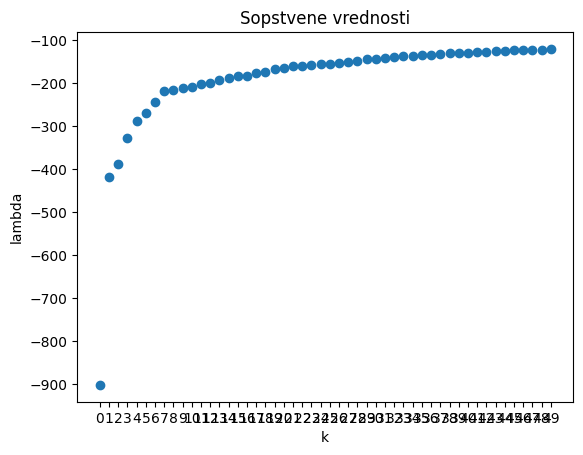

In [72]:
# 20) Sprovesti sprektralnu analizu i proceniti potencijalne kandidate za broj komuna u mreži.
# Uporediti rezultat sa dendogramom konstruisanim Girvan-Newman metodom.


# TODO
adjacency_eigen_values = []
adjacency_eigen_vectors = []

distance_eigen_values = []
distance_eigen_vectors = []

combined_eigen_values = []
combined_eigen_vectors = []

def analyze_by_function(G:nx.Graph, similarity_function, function_name, plot = False):
    id_to_order_map, order_to_id_map = make_id_and_order_dicts(G)
    L = make_laplacian_matrix(BgNetL,(id_to_order_map, order_to_id_map), similarity_function)
    
    eigen_values, eigen_vectors = linalg.eig(L)
    zipped_list = list(zip(eigen_values, eigen_vectors))
    zipped_list.sort(key=lambda t: t[0])
    eigen_values_sorted, eigen_vectors_sorted = zip(*zipped_list[:50])
    error = abs(eigen_values_sorted[0])
    print(f"Greska je {error}")
    
    if plot:
        plt.plot(eigen_values_sorted, 'o')
        plt.xticks(range(len(eigen_values_sorted)))
        plt.xlabel("k")
        plt.ylabel("lambda")
        plt.title("Sopstvene vrednosti")
        plt.show() # Susednost: 5, 8, 16, 20, 25, 34, 44, 48...

    return

    indices = []
    if function_name == "adjacency":
        indices = [5, 20, 44]

    eigen_values_to_save = [eigen_values_sorted[index] for index in indices]
    eigen_vectors_to_save = [eigen_vectors_sorted[index] for index in indices]
    
    file_name_start = "spectral_analysis_"
    with open(f"{spectral_path}/{file_name_start}_{function_name}_indices.txt", "w") as file_values:
        for index in indices:
            file_values.write(str(index))
            file_values.write("\n")
    with open(f"{spectral_path}/{file_name_start}_{function_name}_values.txt", "w") as file_index:
        for eigen_value in eigen_values_to_save:
            file_index.write(str(eigen_value))
            file_index.write("\n")   
    for ord, eigen_vector in enumerate(eigen_vectors_to_save):
        filename = f"{spectral_path}/{file_name_start}_{function_name}_vectors_{indices[ord]}.csv"
        np.savetxt(filename, eigen_vector, delimiter=",")




    
    
modes = ["adjacency", "distance", "combined", "skip_analysis"]
functions = {modes[0]: adjacency_function, modes[1]: distance_function, modes[2] : combined_function}
mode = modes[1]

if mode != modes[3]:
    analyze_by_function(BgNetL, functions[mode], mode, plot=True)


In [ ]:
# 21) Izvršiti spektralno klasterisanje na osnovu konstruisanih funkcija sličnosti i procenjenog broja klastera.
# Vizuelizovati klasterisanje na mapi gradskog saobraćaja, tako što će se stanice koje su svrstane u isti klaster crtati istom bojom.
# Izabrati boje koje daju dobar kontrast u odnosu na mapu i boje drugih klastera.

# TODO

In [ ]:
# 22) Ko su akteri koji se mogu okarakterisati kao ključni brokeri (mostovi) u mreži?
# Šta ih čini brokerima?
# Porediti odgovor sa brokerima dobijenim u pitanju 17.

# TODO

### Analiza mreže BGNetLWalk [5 poena]
23) Ponoviti sve analize koje imaju smisla za BGNetLWalk mrežu. Uporediti i komentarisati dobijene rezultate sa BGNetL mrežom. Da li se uočavaju značajnije promene u mreži?

In [ ]:
# 23) Ponoviti sve analize koje imaju smisla za BGNetLWalk mrežu.
# Uporediti i komentarisati dobijene rezultate sa BGNetL mrežom.
# Da li se uočavaju značajnije promene u mreži?

# TODO: pokrenuti notebook sa drugačijim parametrima
